# Title

ODE:

\begin{equation*}
    \frac{d \varphi}{d t} + \varphi A + A^T \varphi + \varphi B \vartheta + \vartheta^T B^T \varphi + \sum_{i=1}^d (C_i^T + \vartheta^T D_i^T) \varphi (C_i + D_i \vartheta) - Q - S^T \vartheta - \vartheta^T S - \vartheta^T R \vartheta  = 0
\end{equation*}
where
\begin{equation*}
    \vartheta = \bigg[ \sum_{i=1}^d D_i^T \varphi D_i - 2 R \bigg]^{-1} \bigg( S - B^T \varphi - \sum_{i=1}^d D_i^T \varphi C_i \bigg)
\end{equation*}
with
\begin{equation*}
    \varphi \in R^{n \times n}, \quad A \in R^{n \times n}, \quad C_i \in R^{n \times n}, \quad B \in R^{n \times m}, \quad D_i \in R^{n \times m}, \quad Q \in R^{n \times n}R^{n \times n}, \quad S \in R^{m \times n}, \quad R \in R^{m \times m}
\end{equation*}
and terminal conditions
\begin{equation*}
    \varphi(T) = - G(T) \in R^{n \times n}
\end{equation*}

In [21]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.integrate import RK45
from scipy.integrate import RK23
import scipy

In [22]:
Q = np.array([[16,1], [1,16]])  # Symmetric
S = np.array([[0,0], [0,0]])
R = np.array([[10,5], [5,10]])
A = np.array([[2,1], [1,2]])
B = np.array([[3,1], [1,3]])
C_1 = np.array([[1,5], [5,1]])
C_2 = np.array([[7,1], [1,7]])
D_1 = np.array([[4,1], [1,4]])
D_2 = np.array([[1,18], [18,1]])
G_T = np.array([-1, -2, -2, -1])

In [23]:
T = 10
t0 = 6
S = np.random.rand(2,2)
G_T = - np.reshape(S @ S.T, (4,))
G_T = np.array([-1, -2, -2, -1])
G_T_inv = np.reshape(np.linalg.inv(np.reshape(G_T, (2,2))), (4,))

In [24]:
def derivative(t,y):
    
    y = np.reshape(y, (2,2))

    #theta = np.linalg.inv(D_1.T @ y @ D_1 + D_2.T @ y @ D_2 - R) @ (- B.T @ y - D_1.T @ y @ C_1 - D_2.T @ y @ C_2)
    theta = np.linalg.inv(D_1.T @ y @ D_1 - R) @ (- B.T @ y - D_1.T @ y @ C_1)
    #value = Q + theta.T @ R @ theta - 2 * y @ A  - 2* y @ B @ theta - (C_1.T + theta.T @ D_1.T) @ y @ (C_1 + D_1 @ theta) - (C_2.T + theta.T @ D_2.T) @ y @ (C_2 + D_2 @ theta)
    value = Q + theta.T @ R @ theta - 2 * y @ A  - 2* y @ B @ theta - (C_1.T + theta.T @ D_1.T) @ y @ (C_1 + D_1 @ theta)
    return value

solution = RK45(derivative,
                t0=10, 
                y0=G_T, 
                t_bound=t0,
                rtol=0.000001,
                vectorized=True)

# collect data
t_values = [T]
y_values0 = [G_T[0]]
y_values1 = [G_T[1]]
y_values2 = [G_T[2]]
y_values3 = [G_T[3]]
for i in range(1000):
    # get solution step state
    solution.step()
    t_values.append(solution.t)
    y_values0.append(solution.y[0])
    y_values1.append(solution.y[1])
    y_values2.append(solution.y[2])
    y_values3.append(solution.y[3])
    # break loop after modeling is finished
    if solution.status == 'finished':
        break

# Dual Problem

\begin{align*}
    \frac{d \tilde{P}}{d t} + \tilde{P} \tilde{\vartheta} - \tilde{P} A^T - \tilde{P} \sum_{i=1}^d C_i^T \vartheta_i + \tilde{\vartheta}^T \tilde{P} - A \tilde{P} -\sum_{i=1}^d \tilde{\vartheta}_i C_i \tilde{P} - \sum_{i=1}^d\tilde{\vartheta}_i^T\tilde{P} \tilde{\vartheta}_i - \tilde{\vartheta}^T \tilde{Q}\tilde{\vartheta}\\
    - 2\tilde{\vartheta}^T \tilde{S}(B^T + \sum_{i=1}^d D_i^T \vartheta_i) - (B + \sum_{i=1}^d\tilde{\vartheta}_i^T D_i)\tilde{R} (B^T + \sum_{i=1}^d D_i^T \tilde{\vartheta}_i) = 0
\end{align*}

In [25]:
Q_tilde = np.linalg.inv(Q) - np.linalg.inv(Q) @ S.T @ np.linalg.inv(S @ np.linalg.inv(Q) @ S.T - R) @ S @ np.linalg.inv(Q)
R_tilde = np.linalg.inv(R) - np.linalg.inv(R) @ S @ np.linalg.inv(S.T @ np.linalg.inv(R) @ S - np.linalg.inv(Q)) @ S.T @ np.linalg.inv(R)
S_tilde = np.linalg.inv(S @ np.linalg.inv(Q) @ S.T - R) @ S @ np.linalg.inv(Q)

In [26]:
Q_tilde = np.linalg.inv(Q)
R_tilde = np.linalg.inv(R)

In [27]:
def derivative_dual(t,y):
    
    y = np.reshape(y, (2,2))

    #theta_2 = np.linalg.inv(y - D_2 @ R_tilde @ D_2.T - D_2 @ R_tilde @ D_1.T @ np.linalg.inv(y - D_1 @ R_tilde @ D_1.T) @ D_1 @ R_tilde @ D_2.T) @ (C_2 @ y + D_2 @ R_tilde @ B.T + D_2 @ R_tilde @ D_1.T @ np.linalg.inv(y - D_1 @ R_tilde @ D_1.T) @ (C_1 @ y + D_1 @ R_tilde @ B.T) )
    #theta_1 = np.linalg.inv(y - D_1 @ R_tilde @ D_1.T) @ (C_1 @ y + D_1 @ R_tilde @ B.T + D_1 @ R_tilde @ D_2.T @ theta_2)
    theta_1 = np.linalg.inv(y - D_1 @ R_tilde @ D_1.T) @ (C_1 @ y + D_1 @ R_tilde @ B.T)
    theta = np.linalg.inv(Q_tilde) @ y

    #value = -2* y @ theta + 2*y @ A.T + 2 * y @ C_1.T @ theta_1 + 2 * y @ C_2.T @ theta_2 + theta_1.T @ y @ theta_1 + theta_2 @ y @ theta_2 + theta.T @ Q_tilde @ theta + (B + theta_1.T @ D_1 + theta_2.T @ D_2) @ R_tilde @ (B.T + D_1.T @ theta_1 + D_2.T @ theta_2)
    value = -2* y @ theta + 2*y @ A.T + 2 * y @ C_1.T @ theta_1 + theta_1.T @ y @ theta_1 + theta.T @ Q_tilde @ theta + (B + theta_1.T @ D_1) @ R_tilde @ (B.T + D_1.T @ theta_1)
    value3 = -y @ Q @ y + 2 * A @ y - y @ C_1.T @ np.linalg.inv(D_1 @ R_tilde @ D_1.T - y) @ C_1 @ y - 2 * B @ R_tilde @ D_1.T @ np.linalg.inv(D_1 @ R_tilde @ D_1.T - y) @ C_1 @ y - B @ (R_tilde @ D_1.T @ np.linalg.inv(D_1 @ R_tilde @ D_1.T - y) @ D_1 @ R_tilde - R_tilde) @ B.T
    return value3


solution_dual = RK45(derivative_dual, 
                     t0=10, 
                     y0=G_T_inv,
                     t_bound=t0,
                     rtol=0.0000001,
                     vectorized=True)
# collect data
t_values_dual = [T]
y_values0_dual = [G_T[0]]
y_values1_dual = [G_T[1]]
y_values2_dual = [G_T[2]]
y_values3_dual = [G_T[3]]
for i in range(1000):
    # get solution step state
    solution_dual.step()
    t_values_dual.append(solution_dual.t)
    y_array_dual = np.linalg.inv(np.reshape(np.array([solution_dual.y[0], solution_dual.y[1], solution_dual.y[2], solution_dual.y[3]]), (2,2)))
    y_array_dual = np.reshape(y_array_dual, (4,))
    y_values0_dual.append(y_array_dual[0])
    y_values1_dual.append(y_array_dual[1])
    y_values2_dual.append(y_array_dual[2])
    y_values3_dual.append(y_array_dual[3])
    # break loop after modeling is finished
    if solution_dual.status == 'finished':
        break

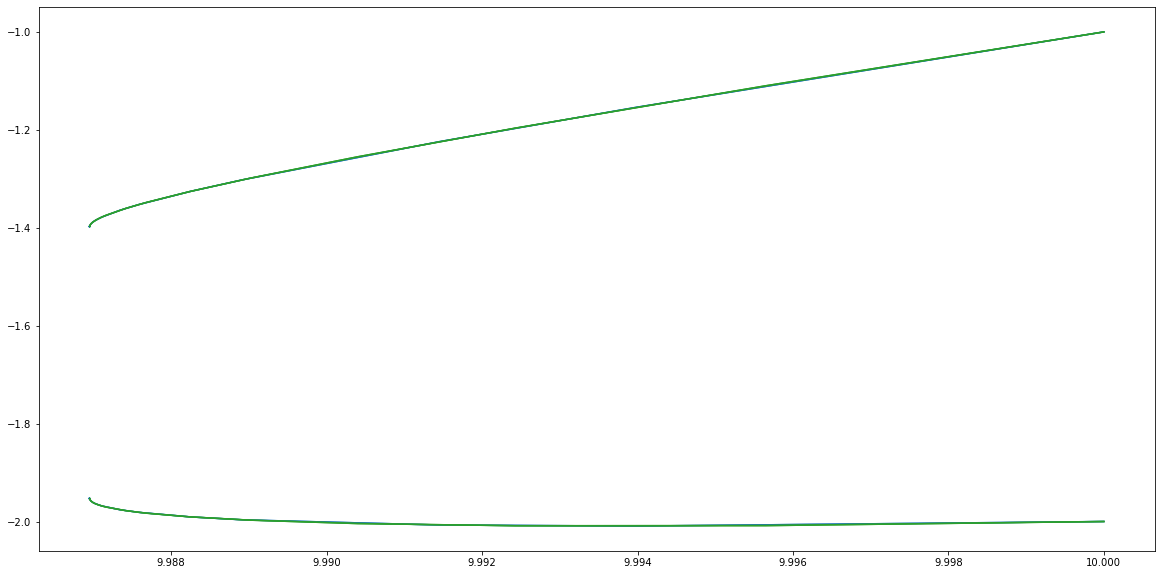

In [28]:
plt.figure(figsize=(20,10))

plt.plot(t_values, y_values0, color='C0')
plt.plot(t_values, y_values1, color='C0')
plt.plot(t_values, y_values2, color='C0')
plt.plot(t_values, y_values3, color='C0')

plt.plot(t_values_dual, y_values0_dual, color='C2')
plt.plot(t_values_dual, y_values1_dual, color='C2')
plt.plot(t_values_dual, y_values2_dual, color='C2')
plt.plot(t_values_dual, y_values3_dual, color='C2')
plt.show()